Type the sar csv file path (default is "sar_mpgu_izh.csv"):


Type the time of the test ending relative to begin of the test in format "hh:mm"


 2:20


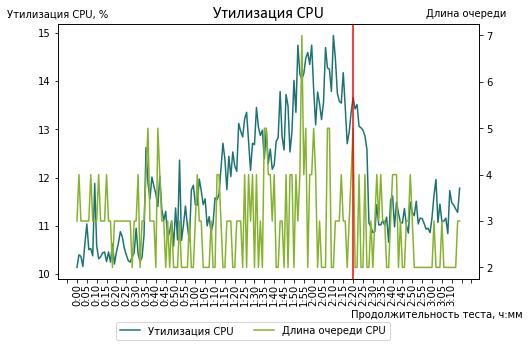

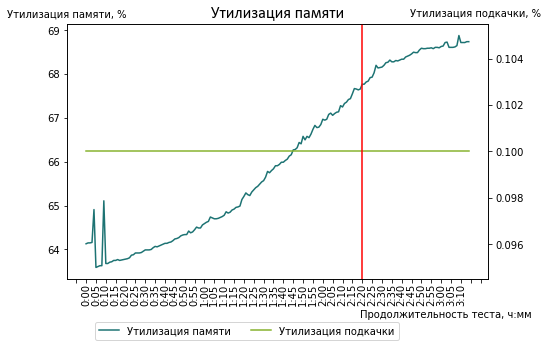

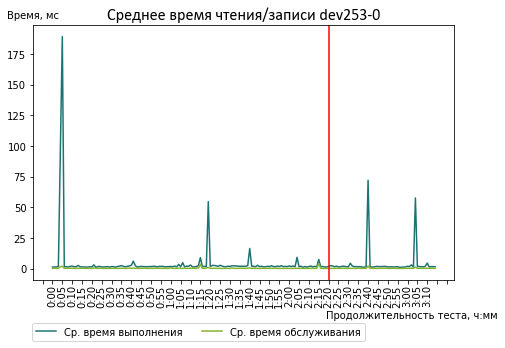

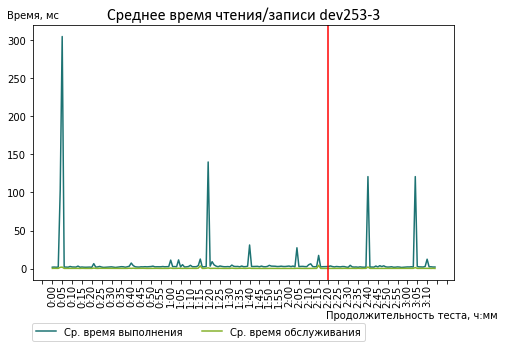

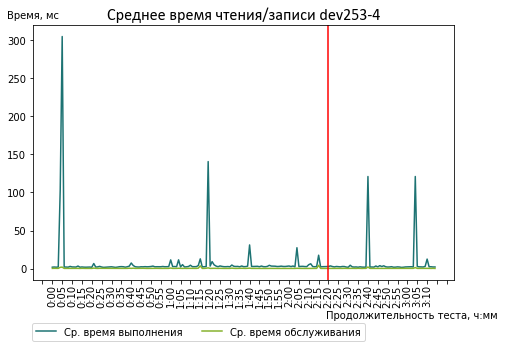

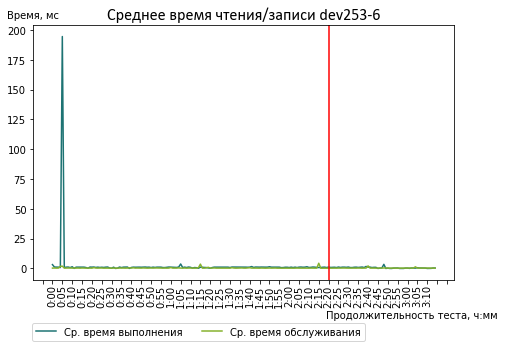

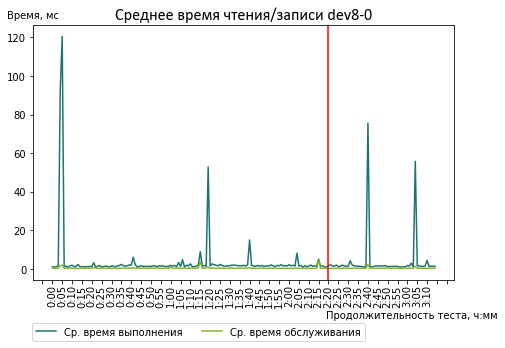

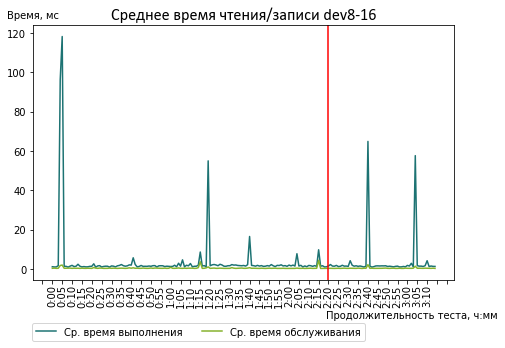

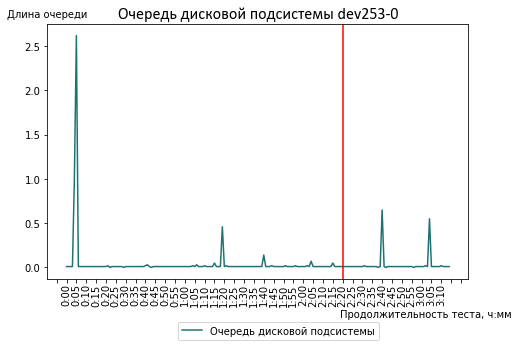

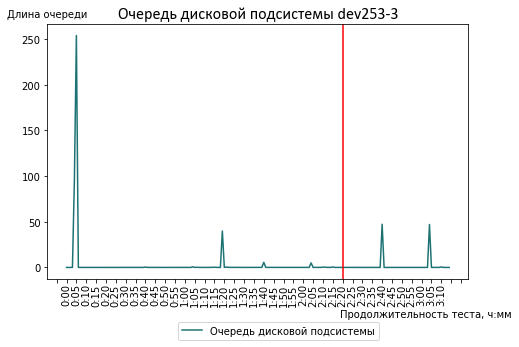

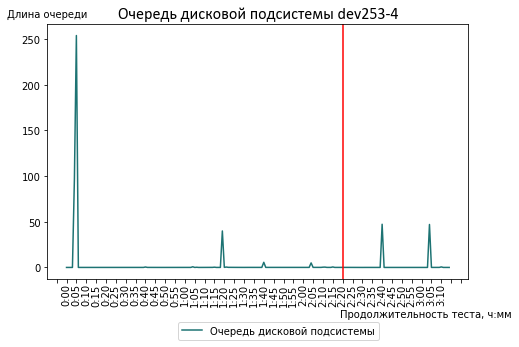

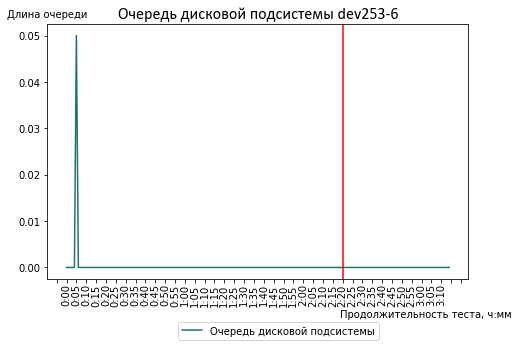

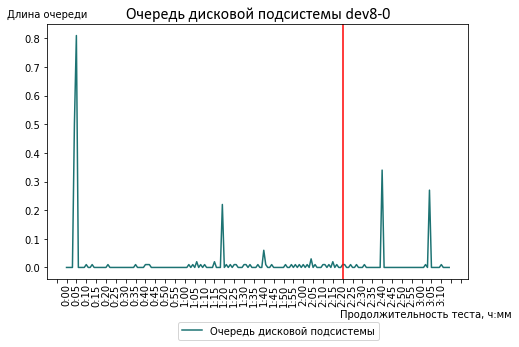

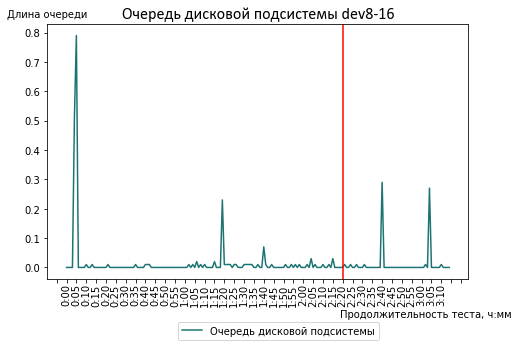

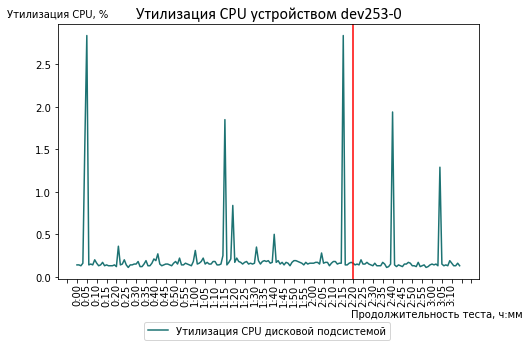

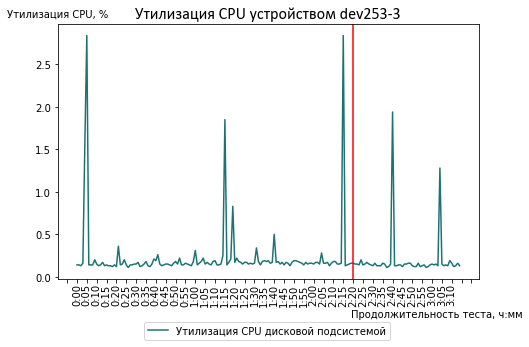

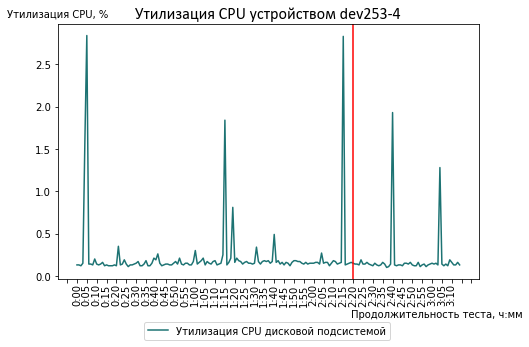

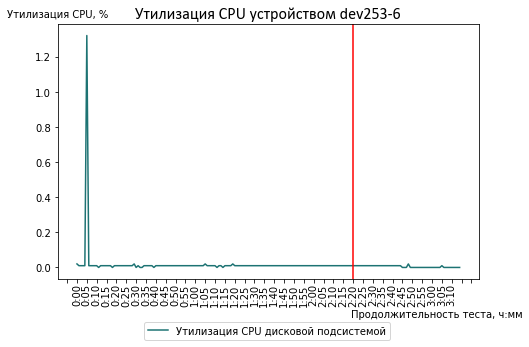

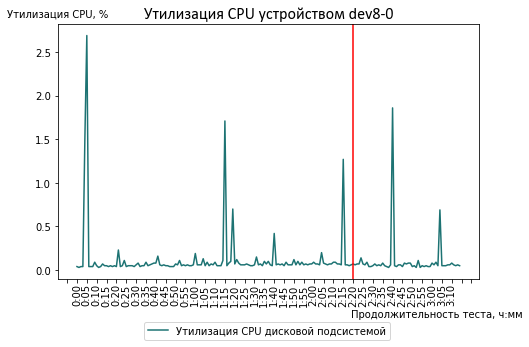

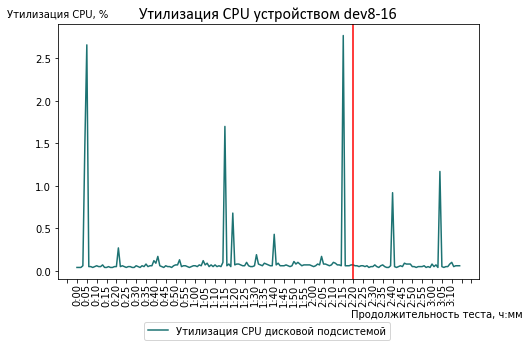

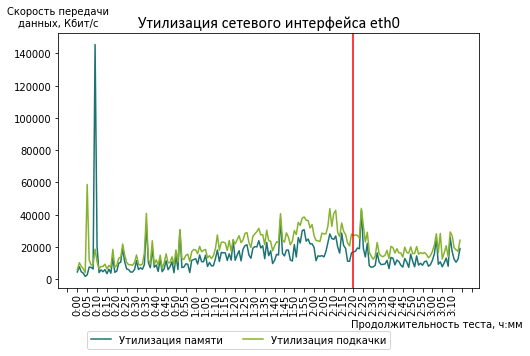

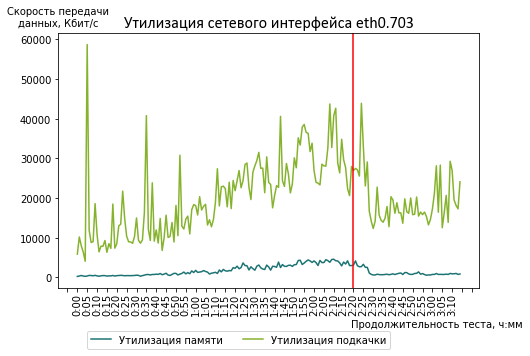

In [1]:
from datetime import timedelta
import collections
from pylab import *
import matplotlib.ticker as ticker

GRAPH_WIDTH = 16.5 / 2.54
GRAPH_HEIGHT = 10 / 2.54

# graphs_config ordered dictionary has the following structure: graphs_config[TRIGGER][METRIC][{METRIC_DATA}]
# where TRIGGER is a substring in sar log
# which is used to recognize the beginnning of data row for some METRICs under this TRIGGER
# METRIC_DATA specification:
#   "type" is used to set the type of graph. It can be "one_graph" or "few_graphs" (always required)
#       "few_graphs" value determines that we need more than one graph based on this data row
#   "separate_by_val_num" sets the column containing parameter for separating the data row
#       set the "separate_by_val_num" value if you have "few_graphs" for this metric
#       example:    "few_graphs" for "await" determines that we need a separate graph for each disk device in sar log
#                   "separate_by_val_num": 1 determines that the first column in row contains device name
#   "val_num" sets the column where the value is stored (always required)
#   "graph" sets the unique name for this graph or group of graphs (always required)
#   "filter" set substring which is required in row for parsing the values
#       example:    "filter": "all" for CPU graph determines that we need only values containing overall usage of CPU
#                   script ignores values for concrete CPU cores
#   "additional_calculation" is used to make some additional calculations for selected values
#       "sub_from_100" is used to get not the "%idle" value from CPU log, but 100% - "%idle"
#       "multiply_by_8" is used to set not the kilobytes value from network log, but kilobits
#   only one metric must have "get_time_arr_from" value. it sets the number of column containing the time values
#   for the graphs. these values will be used for all graphs rendered by script (required only once in the whole dict)

graphs_config = collections.OrderedDict({
    "%idle": {
        "%util": {
            "type": "one_graph",
            "graph": "CPU",
            "val_num": 10,
            "filter": "all",
            "additional_calculation": "sub_from_100"
        }
    },
    "runq-sz": {
        "runq-sz": {
            "type": "one_graph",
            "graph": "CPU",
            "val_num": 1,
            "get_time_arr_from": 0
        },
        "ldavg-1": {
            "type": "one_graph",
            "graph": "load_avg",
            "val_num": 3
        },
        "ldavg-5": {
            "type": "one_graph",
            "graph": "load_avg",
            "val_num": 4
        },
        "ldavg-15": {
            "type": "one_graph",
            "graph": "load_avg",
            "val_num": 5
        }
    },
    "%memused": {
        "%memused": {
            "type": "one_graph",
            "graph": "memory",
            "val_num": 3
        }
    },
    "%swpused": {
        "%swpused": {
            "type": "one_graph",
            "graph": "memory",
            "val_num": 3
        }
    },
    "await": {
        "await": {
            "type": "few_graphs",
            "separate_by_val_num": 1,
            "graph": "disk_read_write",
            "val_num": 7
        },
        "svctm": {
            "type": "few_graphs",
            "separate_by_val_num": 1,
            "graph": "disk_read_write",
            "val_num": 8
        },
        "avgqu-sz": {
            "type": "few_graphs",
            "separate_by_val_num": 1,
            "graph": "disk_queue",
            "val_num": 6
        },
        "%util": {
            "type": "few_graphs",
            "separate_by_val_num": 1,
            "graph": "cpu_util_by_disk",
            "val_num": 9
        }
    },
    "txkB/s": {
        "rxkB/s": {
            "type": "few_graphs",
            "separate_by_val_num": 1,
            "graph": "network",
            "val_num": 4,
            "additional_calculation": "mulpitly_by_8"
        },
        "txkB/s": {
            "type": "few_graphs",
            "separate_by_val_num": 1,
            "graph": "network",
            "val_num": 5,
            "additional_calculation": "mulpitly_by_8"
        }

    }
})

# the key in graphs_rendering_config ordered dictionary must be one of the values of "graph" field from previous dict
#   "title", "x_label" are determining graph title and X-axis label
#   "type" is used to set the type of graph. It can be "graph" or "few_graphs" (always required)
#   other values in graphs_rendering_config[key] must be dictionaries
#       each dict is a separate line on the graph
#       key of dict is not important
#       label is a label for this line on the graph
#       units is a label for the Y-axis scale
#       color sets the color of the line
#       y_axis determines if this line uses Y-axis scale on the left side (primary)
#           or needs an additional scale on the right side (secondary)
#       data_source is the name of graph from previous dict
#       data_row is the metric name from previous dict

graphs_rendering_config = collections.OrderedDict({
    "CPU": {
        "title": "Утилизация CPU",
        "x_label": "Продолжительность теста, ч:мм",
        "type": "graph",
        "CPU_util": {
            "label": "Утилизация CPU",
            "units": "Утилизация CPU, %",
            "color": "#1D7373",
            "y_axis": "primary",
            "data_source": "CPU",
            "data_row": "%util"
        },
        "Queue": {
            "label": "Длина очереди CPU",
            "units": "Длина очереди",
            "color": "#86B32D",
            "y_axis": "secondary",
            "data_source": "CPU",
            "data_row": "runq-sz"
        }
    },
    "memory": {
        "title": "Утилизация памяти",
        "x_label": "Продолжительность теста, ч:мм",
        "type": "graph",
        "%memused": {
            "label": "Утилизация памяти",
            "units": "Утилизация памяти, %",
            "color": "#1D7373",
            "y_axis": "primary",
            "data_source": "memory",
            "data_row": "%memused"
        },
        "%swpused": {
            "label": "Утилизация подкачки",
            "units": "Утилизация подкачки, %",
            "color": "#86B32D",
            "y_axis": "secondary",
            "data_source": "memory",
            "data_row": "%swpused"
        }
    },
    "disk_read_write": {
        "title": "Среднее время чтения/записи",
        "x_label": "Продолжительность теста, ч:мм",
        "type": "few_graphs",
        "await": {
            "label": "Ср. время выполнения",
            "units": "Время, мс",
            "color": "#1D7373",
            "y_axis": "primary",
            "data_source": "disk_read_write",
            "data_row": "await"
        },
        "svctm": {
            "label": "Ср. время обслуживания",
            "units": "Время, мс",
            "color": "#86B32D",
            "y_axis": "primary",
            "data_source": "disk_read_write",
            "data_row": "svctm"
        }
    },
    "disk_queue": {
        "title": "Очередь дисковой подсистемы",
        "x_label": "Продолжительность теста, ч:мм",
        "type": "few_graphs",
        "await": {
            "label": "Очередь дисковой подсистемы",
            "units": "Длина очереди",
            "color": "#1D7373",
            "y_axis": "primary",
            "data_source": "disk_queue",
            "data_row": "avgqu-sz"
        }
    },
    "cpu_util_by_disk": {
        "title": "Утилизация CPU устройством",
        "x_label": "Продолжительность теста, ч:мм",
        "type": "few_graphs",
        "await": {
            "label": "Утилизация CPU дисковой подсистемой",
            "units": "Утилизация CPU, %",
            "color": "#1D7373",
            "y_axis": "primary",
            "data_source": "cpu_util_by_disk",
            "data_row": "%util"
        }
    },
    "network": {
        "title": "Утилизация сетевого интерфейса",
        "x_label": "Продолжительность теста, ч:мм",
        "type": "few_graphs",
        "rxkB/s": {
            "label": "Утилизация памяти",
            "units": "Скорость передачи\nданных, Кбит/с",
            "color": "#1D7373",
            "y_axis": "primary",
            "data_source": "network",
            "data_row": "rxkB/s"
        },
        "txkB/s": {
            "label": "Утилизация подкачки",
            "units": "Скорость передачи\nданных, Кбит/с",
            "color": "#86B32D",
            "y_axis": "primary",
            "data_source": "network",
            "data_row": "txkB/s"
        }
    },
})


# this function is used to render the graphs using matplotlib
# time_row is a list instance, containing x-axis values
# graph_data is a dict instance containing values from graphs_rendering_config
# every graph_data has all the fields from specification above + every line has list named "values"
# "values" list stores y-axis values for the line
# len("values") == len(time_row) required!
# subrow_name is a string added to the graph title
def show_plot(time_row, graph_data, subrow_name=False):
    plot = plt.figure(figsize=(GRAPH_WIDTH, GRAPH_HEIGHT))
    y_axis = {}
    lines = {}
    for line_key, line_data in graph_data.items():
        if (isinstance(line_data, dict)):
            if line_data["y_axis"] == "primary":
                if "primary" not in y_axis:
                    y_axis["primary"] = plot.add_axes([0.1, 0.1, 0.9, 0.9])
                    plt.xticks(rotation=90)
                    y_axis["primary"].xaxis.set_major_locator(ticker.MultipleLocator(5))  # x-axis interval
                    y_axis["primary"].tick_params(axis='x', pad=1)  # x-axis margin from scale to label
                    y_axis["primary"].xaxis.set_label_coords(0.90, -0.12)  # x-axis label coords
                    y_axis["primary"].yaxis.set_label_coords(0, 1.02)  # y-axis label coords
                    if isinstance(subrow_name, str):
                        graph_title = graph_data["title"] + " " + subrow_name
                    else:
                        graph_title = graph_data["title"]
                    y_axis["primary"].set_title(graph_title, {'fontname': 'Calibri'}, size=16) # graph title
                    y_axis["primary"].set_xlabel(graph_data["x_label"])  # x-axis title
                    y_axis["primary"].set_ylabel(line_data["units"], rotation='horizontal')  # y-axis label

                lines["primary"] = y_axis["primary"].plot(time_row, line_data["values"], line_data["color"],
                                                          label=line_data["label"])
            if line_data["y_axis"] == "secondary":
                if "secondary" not in y_axis:
                    y_axis["secondary"] = y_axis["primary"].twinx()
                    y_axis["secondary"].xaxis.set_major_locator(ticker.MultipleLocator(5))  # x-axis interval
                    y_axis["secondary"].yaxis.set_label_coords(0.97, 1.06)  # secondary y-axis label coords
                    y_axis["secondary"].set_ylabel(line_data["units"],
                                                   rotation='horizontal')  # secondary y-axis label
                lines["secondary"] = y_axis["secondary"].plot(time_row, line_data["values"], line_data["color"],
                                                              label=line_data["label"])

    if "primary" in lines and "secondary" in lines:
        lines = lines["primary"] + lines["secondary"]
        labels = [i.get_label() for i in lines]
        plt.legend(lines, labels, bbox_to_anchor=(0.2, -0.25, 0.6, .102), loc=0, ncol=2)
    else:
        plt.legend(bbox_to_anchor=(0.2, -0.25, 0.6, .102), loc=0, ncol=2)

    plt.axvline(x=end_time, color='r')
    show()


default_filepath = 'sar_mpgu_izh.csv'
print('Type the sar csv file path (default is \"sar_mpgu_izh.csv\"):')
filepath = str(input())
if filepath == '':
    filepath = default_filepath

print('Type the time of the test ending relative to begin of the test in format "hh:mm"')
end_time = input()
if end_time[0] == '0':
    end_time = end_time[1:]

graphs = collections.OrderedDict({})
time_arr = []

current_trigger = ''
for graph_config in graphs_config.values():
    for field_key, field_data in graph_config.items():
        if field_data["graph"] not in graphs:
            graphs[field_data["graph"]] = collections.OrderedDict({})
        if field_data["type"] == "one_graph":
            graphs[field_data["graph"]][field_key] = []
        elif field_data["type"] == "few_graphs":
            graphs[field_data["graph"]][field_key] = collections.OrderedDict({})

with open(filepath) as logfile:
    for line in logfile:
        # removing multiple spaces from string
        line = re.sub(" +", " ", line.strip())

        # if line is empty it means the section of sar has been ended, reset the trigger
        if line == '':
            current_trigger = ''

        # if trigger is not empty parse current line to get the values
        if current_trigger in graphs_config:
            values = line.split(' ')
            for key, field_data in graphs_config[current_trigger].items():
                value = float(values[field_data["val_num"]])
                if field_data["type"] == "one_graph":
                    if "additional_calculation" in field_data:
                        if field_data["additional_calculation"] == "sub_from_100":
                            value = 100.0 - value
                    if "filter" not in field_data or field_data["filter"] in values:
                        graphs[field_data["graph"]][key].append(value)
                    if "get_time_arr_from" in field_data:
                        time_arr.append(values[field_data["get_time_arr_from"]])
                elif field_data["type"] == "few_graphs":
                    if "additional_calculation" in field_data:
                        if field_data["additional_calculation"] == "mulpitly_by_8":
                            value *= 8.0
                    if "filter" not in field_data or field_data["filter"] in values:
                        local_graph_name = values[field_data["separate_by_val_num"]]
                        if local_graph_name not in graphs[field_data["graph"]][key]:
                            graphs[field_data["graph"]][key][local_graph_name] = []
                        graphs[field_data["graph"]][key][local_graph_name].append(value)

        # if trigger in current line set this trigger
        for trigger, measurements in graphs_config.items():
            if trigger in line:
                current_trigger = trigger

# reformatting time_arr values to match the time relative to the begin of the sar
first_time_val = int(time_arr[0][0:2]) * 60 + int(time_arr[0][3:5])
for i in range(len(time_arr)):
    try:
        time_arr[i] = str(timedelta(minutes=int(time_arr[i][0:2]) * 60 + int(time_arr[i][3:5]) - first_time_val))[:4]
    except:
        time_arr.remove(time_arr[i])

# deleting subrows containing null values
# also deleting odd values from values lists to match the len("values") == len(time_row) condition
subrows_to_delete = []
for graph_name, graph in graphs.items():
    for row_name, row in graph.items():
        # for "one_graph" mode
        if isinstance(row, list):
            while len(row) > len(time_arr):
                # shortening the values list
                del row[-1]
        # for "few_graphs" mode
        elif isinstance(row, dict):
            for subrow_name, subrow in row.items():
                subrow_summary = 0.0
                for value in subrow:
                    subrow_summary += value
                if subrow_summary != 0:
                    while len(subrow) > len(time_arr):
                        # shortening the values list
                        del subrow[-1]
                else:
                    # preparing subrow to delete
                    subrows_to_delete.append([graph_name, row_name, subrow_name])

# deleting empty subrows
for i in range(len(subrows_to_delete)):
    del graphs[subrows_to_delete[i][0]][subrows_to_delete[i][1]][subrows_to_delete[i][2]]

for graph_rendering_config in graphs_rendering_config.values():
    # for "one_graph" mode
    if graph_rendering_config["type"] == "graph":
        plot_input_arr = []
        for key, value in graph_rendering_config.items():
            if isinstance(value, dict):
                value["values"] = graphs[value["data_source"]][value["data_row"]]
                plot_input_arr.append(graph_rendering_config)
        show_plot(time_arr, graph_rendering_config)
    # for "few_graphs" mode
    elif graph_rendering_config["type"] == "few_graphs":
        printed_subrows = []
        for key, value in graph_rendering_config.items():
            if isinstance(value, dict):
                for subrow_name, subrow_value in graphs[value["data_source"]][value["data_row"]].items():
                    if subrow_name not in printed_subrows:
                        value["values"] = graphs[value["data_source"]][value["data_row"]][subrow_name]
                        for key1, value1 in graph_rendering_config.items():
                            if isinstance(value1, dict):
                                if "values" not in value1:
                                    graph_rendering_config[key1]["values"] = \
                                        graphs[value1["data_source"]][value1["data_row"]][subrow_name]
                        printed_subrows.append(subrow_name)
                        show_plot(time_arr, graph_rendering_config, subrow_name)
